In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 目的：スペインの電力価格を予測
# 目的変数：スペインの電力価格(actual_price)
# 評価指標：RME

import numpy as np
import pandas as pd
import os
import pickle
import gc
# 分布確認
!pip install ydata-profiling
from ydata_profiling import ProfileReport
# 可視化
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder,OneHotEncoder
# モデリング
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
import lightgbm as lgb
# 日本語表記
!pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline
# パラメータ最適化
!pip install optuna
import optuna

# 評価指標
from sklearn.metrics import mean_squared_error

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.0/679.0 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.2 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=4c6222e16fd355afab544cd6aacf232c3f5957a5ec7b2e6f47b784fbaa2bb391
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.0
    Uninstalling scipy-1.16.0:
     

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 35.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=fa85f172b116b86c3a1d8a9fd9c85ed7b3e34ad71a10da52d27d9f76640fcec9
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize-matplotlib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 17.2 MB/s eta 0:00:00


In [5]:
file_path = '/content/drive/MyDrive/Colab Notebooks/signate/smbc/'

df_train = pd.read_csv(file_path + 'train.csv')
df_test = pd.read_csv(file_path + 'test.csv')
df_sample = pd.read_csv(file_path + 'sample_submit.csv',header=None)

In [ ]:
print(df_train.shape)
display(df_train.head())
display(df_train.info())

(26280, 92)


,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,seville_weather_main,seville_weather_description,seville_weather_icon,price_actual
0,2015-01-02 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,33,0.0,0.0,0.0,0,800,clear,sky is clear,01n,64.02
1,2015-01-02 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,33,0.0,0.0,0.0,0,800,clear,sky is clear,01n,58.46
2,2015-01-02 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,54.70
3,2015-01-02 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,54.91
4,2015-01-02 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,53.07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 92 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         26280 non-null  object 
 1   generation_biomass                           26259 non-null  float64
 2   generation_fossil_brown_coal/lignite         26260 non-null  float64
 3   generation_fossil_gas                        26260 non-null  float64
 4   generation_fossil_hard_coal                  26260 non-null  float64
 5   generation_fossil_oil                        26259 non-null  float64
 6   generation_hydro_pumped_storage_consumption  26259 non-null  float64
 7   generation_hydro_run_of_river_and_poundage   26259 non-null  float64
 8   generation_hydro_water_reservoir             26260 non-null  float64
 9   generation_nuclear                           26261 non-null  float64
 10

None

In [ ]:
print(df_test.shape)
display(df_test.head())
display(df_test.info())

(8760, 91)


,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,seville_wind_speed,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,seville_weather_main,seville_weather_description,seville_weather_icon
0,2018-01-01 00:00:00+01:00,279.0,0.0,3927.0,895.0,189.0,230.0,1069.0,1893.0,7104.0,...,1,343,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2018-01-01 01:00:00+01:00,282.0,0.0,3948.0,878.0,177.0,1269.0,1058.0,1024.0,7101.0,...,1,343,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2018-01-01 02:00:00+01:00,283.0,0.0,3791.0,890.0,175.0,2197.0,1052.0,888.0,7100.0,...,1,0,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2018-01-01 03:00:00+01:00,280.0,0.0,3671.0,881.0,175.0,2965.0,1032.0,645.0,7101.0,...,1,40,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2018-01-01 04:00:00+01:00,286.0,0.0,3460.0,861.0,173.0,2705.0,1001.0,661.0,7101.0,...,1,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 91 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         8760 non-null   object 
 1   generation_biomass                           8758 non-null   float64
 2   generation_fossil_brown_coal/lignite         8758 non-null   float64
 3   generation_fossil_gas                        8758 non-null   float64
 4   generation_fossil_hard_coal                  8758 non-null   float64
 5   generation_fossil_oil                        8758 non-null   float64
 6   generation_hydro_pumped_storage_consumption  8758 non-null   float64
 7   generation_hydro_run_of_river_and_poundage   8758 non-null   float64
 8   generation_hydro_water_reservoir             8758 non-null   float64
 9   generation_nuclear                           8758 non-null   float64
 10  

None

In [7]:
# 時刻をdatetimeに変換
df_train["time"] = pd.to_datetime(df_train["time"],utc=True)
df_test["time"] = pd.to_datetime(df_test["time"],utc=True)

# 年情報のカラム作成（クロスバリデーション用）
df_train["year"] = df_train["time"].dt.year
df_test["year"] = df_test["time"].dt.year

# ケルビンを摂氏に変換  - 273.15
cities = ["valencia","madrid","bilbao","barcelona","seville"]
for city in cities:
  df_train[f"{city}_temp"] = df_train[f"{city}_temp"] - 273.15
  df_train[f"{city}_temp_min"] = df_train[f"{city}_temp_min"] - 273.15
  df_train[f"{city}_temp_max"] = df_train[f"{city}_temp_max"] - 273.15




## 特徴量エンジニアリング

In [8]:
# 季節性（spring:1,summer:2,autumn:3,winter:4）
def get_season(month):
    if month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3
    else:
        return 4

# 月を取得 → 季節に変換
df_train["month"] = df_train["time"].dt.month
df_train["season"] = df_train["month"].apply(get_season)

# テストデータにも
df_test["month"] = df_test["time"].dt.month
df_test["season"] = df_test["month"].apply(get_season)

In [12]:
# 時間帯（morning:1,afternoon:2,evening:3,night:4）

def get_time_of_day(hour):
    if 5 <= hour < 11:
        return 1
    elif 11 <= hour < 17:
        return 2
    elif 17 <= hour < 21:
        return 3
    else:
        return 4

df_train["hour"] = df_train["time"].dt.hour
df_train["time_of_day"] = df_train["hour"].apply(get_time_of_day)

# テストデータにも
df_test["hour"] = df_test["time"].dt.hour
df_test["time_of_day"] = df_test["hour"].apply(get_time_of_day)

In [13]:
# 週末フラグ

def is_week_end(weekday):
    if weekday in [0,1,2,3,4]:
      return 0
    elif weekday in [0,1,2,3,4]:
      return 1
    else:
      return 2

df_train["weekday"] = df_train["time"].dt.weekday
df_train["is_weekend"] = df_train["weekday"].apply(is_week_end)

# テストデータにも
df_test["weekday"] = df_test["time"].dt.weekday
df_test["is_weekend"] = df_test["weekday"].apply(is_week_end)

In [104]:
# 発電量の和
generation_columns = [col for col in df_train.columns if 'generation' in col]
df_train['generation_sum'] = df_train[generation_columns].sum(axis=1)
df_test['generation_sum'] = df_test[generation_columns].sum(axis=1)

In [116]:
# 発電量のうちの火力発電の構成比[fossil]再生可能エネルギー構成比[renewable]
df_train['generation_sum'] = df_train[generation_columns].sum(axis=1)
df_test['generation_sum'] = df_test[generation_columns].sum(axis=1)

# --- ② 分子になる電源グループ ---
df_train["fossil_total"]     = (
        df_train["generation_fossil_gas"]
      + df_train["generation_fossil_hard_coal"]
      + df_train["generation_fossil_oil"]
)
df_test["fossil_total"]      = (
        df_test["generation_fossil_gas"]
      + df_test["generation_fossil_hard_coal"]
      + df_test["generation_fossil_oil"]
)

df_train["renewable_total"]  = (
        df_train["generation_hydro_pumped_storage_consumption"]
      + df_train["generation_hydro_run_of_river_and_poundage"]
      + df_train["generation_hydro_water_reservoir"]
      + df_train["generation_other_renewable"]
)
df_test["renewable_total"]   = (
        df_test["generation_hydro_pumped_storage_consumption"]
      + df_test["generation_hydro_run_of_river_and_poundage"]
      + df_test["generation_hydro_water_reservoir"]
      + df_test["generation_other_renewable"]
)

# --- ③ 比率を安全に計算（0 除算防止） ---
eps = 1e-6
df_train["fossil_share"]     = df_train["fossil_total"]    / (df_train["generation_sum"] + eps)
df_test["fossil_share"]      = df_test["fossil_total"]     / (df_test["generation_sum"]  + eps)

df_train["renewable_share"]  = df_train["renewable_total"] / (df_train["generation_sum"] + eps)
df_test["renewable_share"]   = df_test["renewable_total"]  / (df_test["generation_sum"]  + eps)

## データ分割＆モデル実装

In [36]:
# カテゴリカルカラムの抜き出し
categorical_cols = [
    col for col in df_train.select_dtypes(include=['object', 'category']).columns
    if col != "price_actual"
    ]
# 数値カラムの抜き出し
numerical_cols = [
    col for col in df_train.select_dtypes(include=['int64', 'float64']).columns
    ]
print('*'*20,'実行結果確認','*'*20,)
print(f'カテゴリ{categorical_cols}')
print(f'数値{numerical_cols}')

******************** 実行結果確認 ********************
カテゴリ['valencia_weather_main', 'valencia_weather_description', 'valencia_weather_icon', 'madrid_weather_main', 'madrid_weather_description', 'madrid_weather_icon', 'bilbao_weather_main', 'bilbao_weather_description', 'bilbao_weather_icon', 'barcelona_weather_main', 'barcelona_weather_description', 'barcelona_weather_icon', 'seville_weather_main', 'seville_weather_description', 'seville_weather_icon']
数値['generation_biomass', 'generation_fossil_brown_coal/lignite', 'generation_fossil_gas', 'generation_fossil_hard_coal', 'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption', 'generation_hydro_run_of_river_and_poundage', 'generation_hydro_water_reservoir', 'generation_nuclear', 'generation_other', 'generation_other_renewable', 'generation_solar', 'generation_waste', 'generation_wind_onshore', 'total_load_actual', 'valencia_temp', 'valencia_temp_min', 'valencia_temp_max', 'valencia_pressure', 'valencia_humidity', 'valencia_wi

In [125]:
# 訓練データ、テストデータ作成（＝目的変数分離）
x_train = df_train[[
    'year',
    'generation_fossil_gas',
    'generation_fossil_hard_coal',
    'generation_fossil_oil',
    'generation_hydro_pumped_storage_consumption',
    'generation_hydro_run_of_river_and_poundage',
    'generation_hydro_water_reservoir',
    'generation_other_renewable',
    'total_load_actual',
    "season",
    "time_of_day",
    "is_weekend",
    #'generation_sum',
    "fossil_share",
    "renewable_share"
    ]]
y_train = df_train['price_actual']
x_test = df_test[[
    'generation_fossil_gas',
    'generation_fossil_hard_coal',
    'generation_fossil_oil',
    'generation_hydro_pumped_storage_consumption',
    'generation_hydro_run_of_river_and_poundage',
    'generation_hydro_water_reservoir',
    'generation_other_renewable',
    'total_load_actual',
    "season",
    "time_of_day",
    "is_weekend",
    #'generation_sum',
    "fossil_share",
    "renewable_share"
    ]]

In [118]:
# モデルの関数化

''' LightGBMモデルの関数
  arg:
    input_x:trainデータの説明変数
    input_y:trainデータの目的変数
    input_test:testデータ
    params:LightGBMのパラメータ。辞書型を想定

  return:
    oof:訓練データ全体の各行について、「自分が検証データになったときの予測」を保持した配列。
    preds:交差検証の各 fold で得られたテストデータの予測確率を累積し、最後に fold 数で割って平均したもの。
    rmse_list:RMSE評価のスコア結果
    feature_importance:特徴量の重要度
  '''

def light_gbm_model(input_x,input_y,input_test,params):

  # 検証対象年リスト
  valid_years = [2016, 2017]

  # oof:out of fold/テスト結果格納/スコアリスト
  oof = np.zeros(len(y_train))
  preds = np.zeros(len(x_test))
  rmse_list = []

  for i, valid_year in enumerate(valid_years):
    print("#" * 15, f"Fold {i+1}（検証年: {valid_year}）", "#" * 15)

    # 時系列に基づいてインデックス指定
    train_idx = input_x[input_x["year"] < valid_year].index
    valid_idx = input_x[input_x["year"] == valid_year].index

    x_tr, y_tr = input_x.loc[train_idx].drop(columns="year"), input_y.loc[train_idx]
    x_va, y_va = input_x.loc[valid_idx].drop(columns="year"), input_y.loc[valid_idx]

    # モデルを訓練する
    lgb_model = lgb.LGBMRegressor(**params)
    lgb_model.fit(
        x_tr, y_tr,
        eval_set=[(x_va, y_va)],
        callbacks=[
          lgb.early_stopping(stopping_rounds=100), #100に変えてもよいかも
          lgb.log_evaluation(period=10) # verboseの設定
          ]
      )
    # 検証用データに対する予測を書き込む
    y_pred = lgb_model.predict(x_va)
    oof[valid_idx] = y_pred

    # テストデータ予測を累積
    preds += lgb_model.predict(input_test)

    # RMSE を計算（squared=False で平方根を取る）
    mse = mean_squared_error(y_va, y_pred)
    rmse = np.sqrt(mse)
    rmse_list.append(rmse)
    print(f"RMSE: {rmse:.4f}")

  # 最後にテスト予測を平均化
  preds /= len(valid_years)

  # 特徴量名とimportanceを取得
  feature_importance = pd.DataFrame({
      'feature': x_tr.columns,
      'importance': lgb_model.feature_importances_,  # splitの数
      'gain': lgb_model.booster_.feature_importance(importance_type='gain')  # gain値
  })


  return oof,preds,rmse_list,feature_importance

In [114]:
# パラメータ
params = {
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':'rmse',
    'learning_rate':0.05,
    'num_leaves':64,
    'max_depth':-1,
    'n_estimators':15000,
    'random_state':123,
    'importance_type':'gain'
}

############### Fold 1（検証年: 2016） ###############
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2327
[LightGBM] [Info] Number of data points in the train set: 8737, number of used features: 13
[LightGBM] [Info] Start training from score 61.358245
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 18.1889
[20]	valid_0's rmse: 17.4816
[30]	valid_0's rmse: 17.247
[40]	valid_0's rmse: 17.1448
[50]	valid_0's rmse: 17.0159
[60]	valid_0's rmse: 16.9514
[70]	valid_0's rmse: 16.9278
[80]	valid_0's rmse: 16.9059
[90]	valid_0's rmse: 16.8923
[100]	valid_0's rmse: 16.7905
[110]	valid_0's rmse: 16.7117
[120]	valid_0's rmse: 16.6666
[130]	valid_0's rmse: 16.654
[140]	valid_0's rmse: 16.645
[150]	valid_0's rmse: 16.6077
[160]	valid_0's rmse: 16.6078
[170]	valid_0'

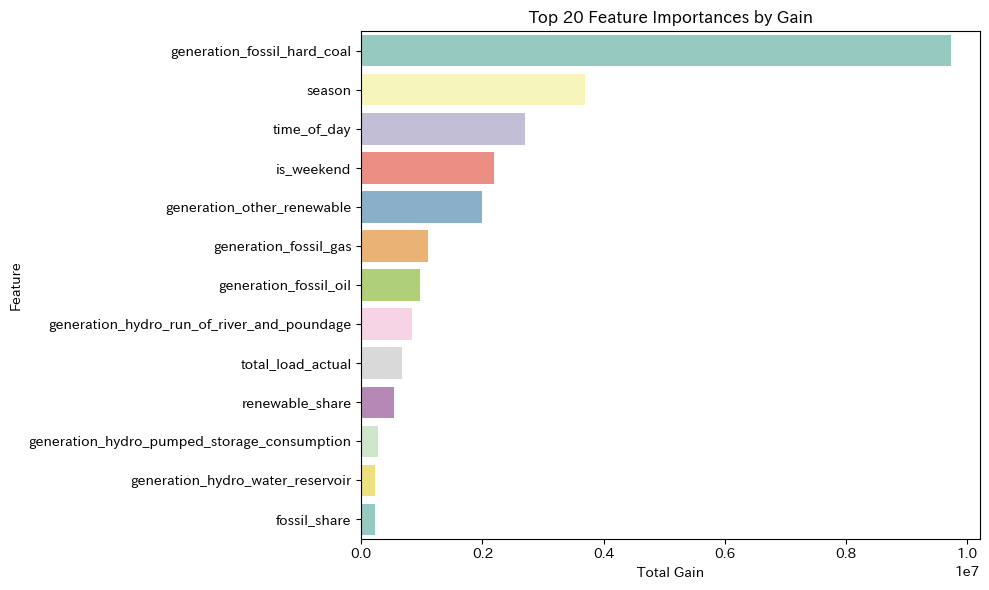

In [126]:
# 関数の実行
oof, preds, rmse_list,feature_importance = light_gbm_model(x_train,y_train,x_test,params)

print("-"*50,"✅結果まとめ✅","-"*50,)

print(f'平均 RMSE: {np.mean(rmse_list):.4f}')
print(f'OOF array shape: {oof.shape}')
print(f'Preds array shape: {preds.shape}')

# ソート
feature_importance = feature_importance.sort_values('gain', ascending=False)

# 上位20個をプロット
plt.figure(figsize=(10, 6))
sns.barplot(
    x='gain',
    y='feature',
    hue='feature',
    data=feature_importance.head(20),
    palette='Set3',
    legend=False
    )
plt.title("Top 20 Feature Importances by Gain")
plt.xlabel("Total Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [124]:
from datetime import date

today = date.today()

df_sub = pd.read_csv(file_path + 'sample_submit.csv',header=None)

submission = pd.DataFrame({
    'time':df_sub.iloc[:, 0] ,
    'pred': preds
})
submission.to_csv(f'submission_{today}.csv', index=False, header=False)
print(f'✅ Submission file saved as submission_{today}.csv')

✅ Submission file saved as submission_2025-07-29.csv
